# ทำนายผลผลิตการเกษตร โดยใช้ผลผลิตปีก่อน ๆ ด้วย Prophet

https://facebook.github.io/prophet/docs/quick_start.html

ขั้นตอนติดตั้ง ให้สร้าง environment ที่ชื่อ oae โดยใช้ environment.yml
และคัดลอกข้อมูล OAE-process มาไว้ใน folder นี้

In [2]:
import numpy as np
import pandas as pd
from fbprophet import Prophet

import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls

from fbprophet.plot import plot_plotly, plot_components_plotly


from utils.preproc import read_yield, get_yeild_area, read_annually_data, read_month_data, read_month_data_area, add_regressor
from utils.preproc import rice_inseason_harvest_season, rice_offseason_harvest_season, corn_harvest_season, cassava_harvest_season, rubber_harvest_season

py.init_notebook_mode(connected=True)

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

Model parameters

In [3]:
# rice in-season
params = {
    'rice_in-season': {
        'yield_file' : 'OAE-process/OAE-ผลผลิตข้าวนาปี.xlsx',
        'cost_file' : 'OAE-process/OAE-ต้นทุนรวมต่อไร่ข้าวนาปี.xlsx',
        'price_file' : 'OAE-process/OAE-ราคาข้าวเปลือกเจ้า.xlsx',
        'harvest' : rice_inseason_harvest_season,
        'seasonality_prior_scale': 0.1,
        'fourier_order': 7,
        'prior_scale': 0.1
    },
    
    'rice_off-season': {
        'yield_file' : 'OAE-process/OAE-ผลผลิตข้าวนาปรัง.xlsx',
        'cost_file' : 'OAE-process/OAE-ต้นทุนรวมต่อไร่ข้าวนาปรัง.xlsx',
        'price_file' : 'OAE-process/OAE-ราคาข้าวเปลือกเจ้า.xlsx',
        'harvest' : rice_offseason_harvest_season,
        'seasonality_prior_scale': 0.1,
        'fourier_order': 5,
        'prior_scale': 0.1
    },
    
    'corn': {
        'yield_file' : 'OAE-process/OAE-ผลผลิตข้าวโพดทั้งหมด.xlsx',
        'cost_file' : 'OAE-process/OAE-ต้นทุนรวมต่อไร่ข้าวโพดเลี้ยงสัตว์.xlsx',
        'price_file' : 'OAE-process/OAE-ราคาข้าวโพดเลี้ยงสัตว์.xlsx',
        'harvest' : corn_harvest_season,
        'seasonality_prior_scale': 0.1,
        'fourier_order': 3,
        'prior_scale': 0.1
    },
    
    'palm': {
        'yield_file' : 'OAE-process/OAE-ผลผลิตปาล์มน้ำมัน.xlsx',
        'cost_file' : 'OAE-process/OAE-ต้นทุนรวมต่อไร่ปาล์มน้ำมัน.xlsx',
        'price_file' : 'OAE-process/OAE-ราคาปาล์มน้ำมัน.xlsx',
        'harvest' : None,
        'seasonality_prior_scale': 10,
        'prior_scale': 0.1
    },
    
    'cassava': {
        'yield_file' : 'OAE-process/OAE-ผลผลิตมันสำปะหลัง.xlsx',
        'cost_file' : 'OAE-process/OAE-ต้นทุนรวมต่อไร่มันสำปะหลัง.xlsx',
        'price_file' : 'OAE-process/OAE-ราคามันสำปะหลังสดคละ.xlsx',
        'harvest' : cassava_harvest_season,
        'seasonality_prior_scale': 0.1,
        'fourier_order': 3,
        'prior_scale': 0.1
    },
    
    'rubber': {
        'yield_file' : 'OAE-process/OAE-ผลผลิตยางพารา.xlsx',
        'cost_file' : 'OAE-process/OAE-ต้นทุนรวมต่อไร่ยางพารา.xlsx',
        'price_file' : ['OAE-process/OAE-ราคาน้ำยางสดคละ.xlsx', 'OAE-process/OAE-ราคายางก้อน.xlsx', 'OAE-process/OAE-ราคายางแผ่นดิบชั้น3.xlsx'],
        'harvest' : rubber_harvest_season,
        'seasonality_prior_scale': 1,
        'fourier_order': 3,
        'prior_scale': 5
    }
}

## User Param: Select Product Type

วิธีใช้ ขั้นที่ 1: เลือกชนิดของผลผลิตทางการเกษตรที่ต้องการ ในตัวแปร `ptype` เช่น ข้าวนาปี (rice_in-season), ข้าวนาปรัง (rice_off-season), ข้าวโพด (corn), ปาล์มน้ำมัน (palm), มันสำปะหลัง (cassava)

In [4]:
ptype = 'rice_off-season'#'rice_off-season'

In [5]:
param = params[ptype]
yield_file = param['yield_file']
cost_file = param['cost_file']
price_file = param['price_file']
is_harvest_season = param['harvest']

In [6]:
df, df_group = read_yield(yield_file)

df_cost = read_annually_data(cost_file)

precipitation_file = 'OAE-process/OAE-ปริมาณน้ำฝน-ฝนตก.xlsx'
df_precip = pd.read_excel(precipitation_file)

# df_price = read_month_data(price_file)

# Dashboard

ขั้นตอนที่ 2 รัน Dashboard

In [7]:
df_group.index[0]

'Suphan Buri'

Total Yield from Feb 2015 to Oct 2019 = 2570861
           y
year        
2015  434765
2016  304677
2017  581641
2018  650768
2019  599010

Predict Yield from Nov 2018 to Oct 2019
RMSE: 32976.77
MAE: 20296.46
Total Error: 5.962 %
Forecast: 634723.87
Ground Truth: 599010


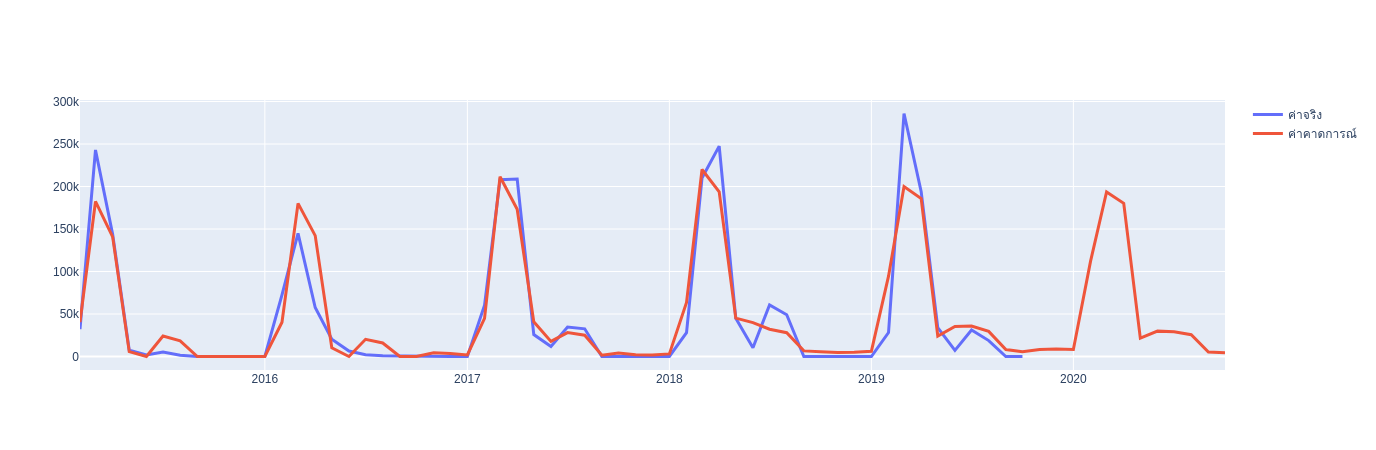

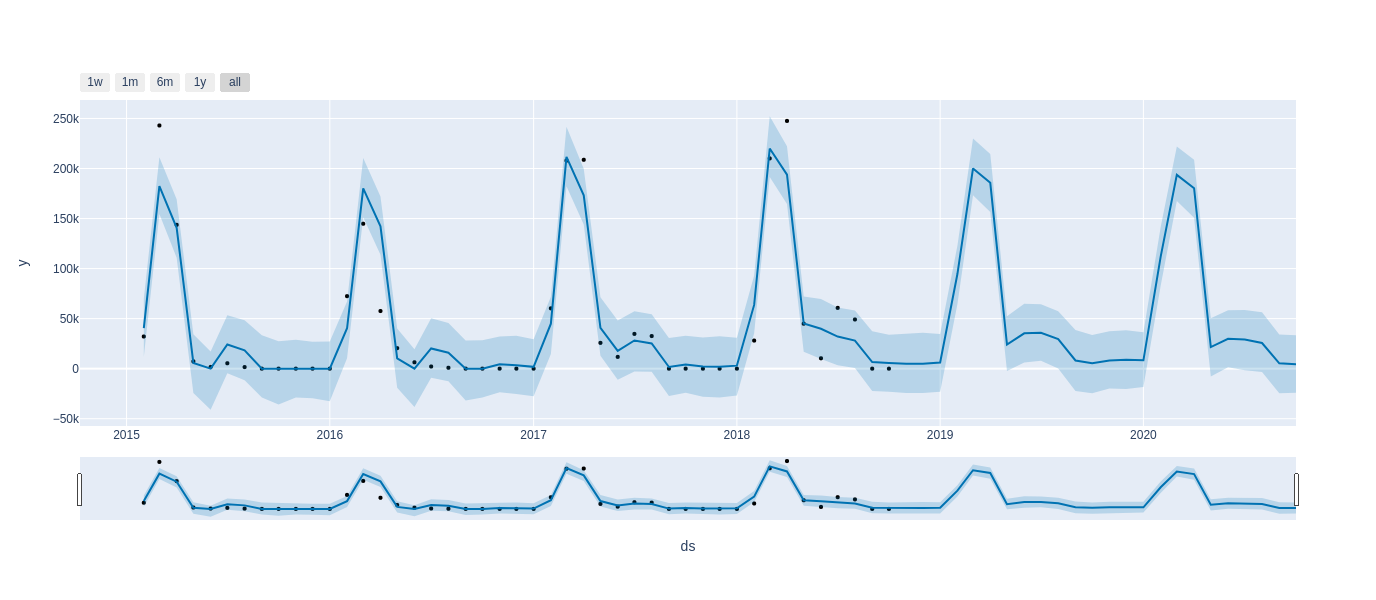

In [8]:
Province=df_group.index[0]
df_yield = get_yeild_area(df, Province)
print(f'Total Yield from {df.date.min().strftime("%b %Y")} to {df.date.max().strftime("%b %Y")} = {df_group.loc[Province,"value"]}')

df_precipitation = read_month_data_area(df_precip, Province)


if ptype == 'rubber':
    df_price1 = read_month_data(price_file[0])
    df_price2 = read_month_data(price_file[1])
    df_price3 = read_month_data(price_file[2])

    col_regressor = ['cost', 'precipitation', 'price_latex', 'price_cup', 'price_sheet']
    @add_regressor([df_cost, df_precipitation, df_price1, df_price2, df_price3], col_regressor)
    def add_features(df):
        return df
else:
    df_price = read_month_data(price_file)

    col_regressor = ['cost', 'precipitation', 'price']
    @add_regressor([df_cost, df_precipitation, df_price], col_regressor)
    def add_features(df):
        return df

df_train, df_test = df_yield[12:], df_yield[:12]
df_train = add_features(df_train).dropna()
if is_harvest_season:
    df_train = df_train.apply(is_harvest_season, axis=1)

df_yield['year'] = pd.DatetimeIndex(df_yield['ds']).year
print(df_yield.groupby('year').sum().head())

model = Prophet(weekly_seasonality=False, daily_seasonality=False)
model.seasonality_prior_scale = param['seasonality_prior_scale']

if is_harvest_season:
    model.add_seasonality(name = 'monthly_harvest_season', 
                          period = 30.5, 
                          fourier_order = param['fourier_order'], 
                          condition_name = 'harvest_season')

for col in col_regressor:
    model.add_regressor(col, 
                        prior_scale = param['prior_scale'], 
                        mode = 'multiplicative')

model.fit(df_train)

future = model.make_future_dataframe(periods=24, freq="MS")
future = add_features(future)

if is_harvest_season:
    future = future.apply(is_harvest_season, axis=1)

forecast = model.predict(future)
forecast.yhat.clip(lower=0, inplace=True)
forecast = forecast.sort_values(by='ds', ascending=False).reset_index().drop(columns=['index'])

# Sanity check that we are evaluating the forecase at the same date
assert(np.all(forecast[12:24]['ds'].to_numpy() == df_test['ds'].to_numpy()))
# Calculate root mean squared error.
print(f'\nPredict Yield from {df_test["ds"].min().strftime("%b %Y")} to {df_test["ds"].max().strftime("%b %Y")}')
print('RMSE: %.2f' % np.sqrt(np.mean((forecast[12:24]['yhat'].to_numpy() - df_test['y'].to_numpy())**2)) )
print('MAE: %.2f' % np.mean(np.abs(forecast[12:24]['yhat'].to_numpy() - df_test['y'].to_numpy())) )

total_error = abs(1 - (np.sum(forecast[12:24]['yhat'].to_numpy()) / np.sum(df_test['y'].to_numpy()))) * 100
print(f"Total Error: {total_error:.3f} %")
print(f"Forecast: {np.sum(forecast[12:24]['yhat'].to_numpy()):.2f}")
print('Ground Truth:', np.sum(df_test['y'].to_numpy()))

py.iplot([
    go.Scatter(x=df_yield['ds'], y=df_yield['y'], name='ค่าจริง', line=dict(width=3)),
    go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='ค่าคาดการณ์', line=dict(width=3)),
#     go.Scatter(x=forecast['ds'], y=forecast['trend'], name='Trend'),
#     go.Scatter(x=df_test['ds'], y=df_test['y'], name='test', marker=dict(color='blue', size=12), line=dict(width=3)),
])

f1 = plot_plotly(model, forecast)
py.iplot(plot_plotly(model, forecast))
f1.write_html("f1.html")

f2 = plot_components_plotly(model, forecast)
py.iplot(plot_components_plotly(model, forecast))
f2.write_html("f2.html")

In [ ]:
fig = go.Figure([
    go.Scatter(x=df_yield['ds'], y=df_yield['y'], name='ค่าจริง', line=dict(width=3)),
    go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='ค่าคาดการณ์', line=dict(width=3)),
#     go.Scatter(x=forecast['ds'], y=forecast['trend'], name='Trend'),
#     go.Scatter(x=df_test['ds'], y=df_test['y'], name='test', marker=dict(color='blue', size=12), line=dict(width=3)),
])

fig.write_html("f0.html")